In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1";

import keras
from keras.applications.vgg16 import VGG16
from keras.datasets import cifar10

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Split data into testing and training

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Display a test example image

In [3]:
import matplotlib.pyplot as plt

plt.imshow(x_train[1])
print("Label: {}".format(y_train[1]))

Label: [9]


# Set data to one-hot encoded format (vector of 10 class binary values)

In [4]:
y_svm_train = y_train
y_train = keras.utils.to_categorical(y_train, 10)

y_svm_test = y_test
y_test = keras.utils.to_categorical(y_test, 10)

# Normalize the images

In [5]:
from tensorflow.keras.applications.vgg16 import preprocess_input

x_test = preprocess_input(x_test)
x_train = preprocess_input(x_train)

# Initialize VGG-16 Model

In [6]:
model = VGG16(weights='none', include_top=False, input_shape=(32,32,3), classes=10)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

# Replace Top Layers of VGG

# from keras.layers import Flatten, Dense
from keras.models import Model

x = model.get_layer('block5_pool').output
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

model_updated = Model(inputs=model.input, outputs=x)
print(model_updated.summary())

In [7]:
from keras.layers import Flatten, Dense
from keras.models import Model

x = model.get_layer('block5_pool').output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

model_updated = Model(inputs=model.input, outputs=x)

In [8]:
def learning_rate_schedule(epoch):
    if epoch <= 10:
        return 1e-4 # 0.00001
    elif epoch <= 20:
        return 1e-5
    elif epoch <= 30:
        return 1e-6
    else:
        return 1e-7
    return LR

In [9]:
model_updated.save_weights('model_initial.h5')

# Perform Training Three Times

In [10]:
from keras import optimizers
from keras.callbacks import EarlyStopping

model_updated.save_weights('model_initial.h5')
training_runs = []
for i in range(3):
    #model_updated.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    model_updated.compile(loss='categorical_crossentropy', optimizer=optimizers.adam(lr=0.0001), metrics=['accuracy'])
    keras.callbacks.LearningRateScheduler(learning_rate_schedule)
    history = model_updated.fit(x_train, y_train, batch_size=128, shuffle=True, epochs=10, validation_data=(x_test, y_test))
    training_runs.append(history)
    model_updated.get_weights()
    if i == 2:
        model_updated.save_weights('model1.h5')
    else:
        model_updated.load_weights('model_initial.h5')
    print()

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 21s 418us/step - loss: 0.8735 - acc: 0.7002 - val_loss: 0.6288 - val_acc: 0.7865
Epoch 2/10
50000/50000 [==============================] - 18s 364us/step - loss: 0.4778 - acc: 0.8387 - val_loss: 0.4918 - val_acc: 0.8360
Epoch 3/10
50000/50000 [==============================] - 19s 374us/step - loss: 0.3334 - acc: 0.8855 - val_loss: 0.4756 - val_acc: 0.8421
Epoch 4/10
50000/50000 [==============================] - 19s 376us/step - loss: 0.2311 - acc: 0.9208 - val_loss: 0.5388 - val_acc: 0.8337
Epoch 5/10
50000/50000 [==============================] - 19s 376us/step - loss: 0.1581 - acc: 0.9463 - val_loss: 0.5317 - val_acc: 0.8482
Epoch 6/10
50000/50000 [==============================] - 19s 375us/step - loss: 0.1149 - acc: 0.9617 - val_loss: 0.5746 - val_acc: 0.8523
Epoch 7/10
50000/50000 [==============================] - 19s 377us/step - loss: 0.0916 - acc: 0.9692 - val_loss: 0.

# Graphs and Metrics

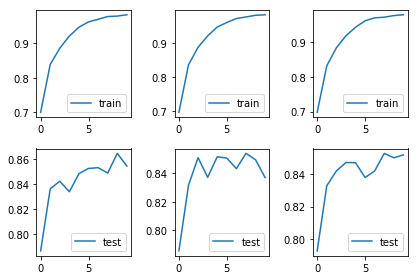

Average training accuracy: 0.9815666666984558
Average testing accuracy: 0.8476333333333333


In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.subplot(2, 3, 1)
plt.plot(training_runs[0].history['acc'])
plt.legend(['train'], loc='lower right')

plt.subplot(2, 3, 2)
plt.plot(training_runs[1].history['acc'])
plt.legend(['train'], loc='lower right')

plt.subplot(2, 3, 3)
plt.plot(training_runs[2].history['acc'])
plt.legend(['train'], loc='lower right')

plt.subplot(2, 3, 4)
plt.plot(training_runs[0].history['val_acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(2, 3, 5)
plt.plot(training_runs[1].history['val_acc'])
plt.legend(['test'], loc='lower right')

plt.subplot(2, 3, 6)
plt.plot(training_runs[2].history['val_acc'])
plt.legend(['test'], loc='lower right')

plt.tight_layout() 

plt.show()

print("Average training accuracy: {}".format(np.mean([training_runs[0].history['acc'][-1], 
                                                     training_runs[1].history['acc'][-1], training_runs[2].history['acc'][-1]])))
print("Average testing accuracy: {}".format(np.mean([training_runs[0].history['val_acc'][-1], 
                                                     training_runs[1].history['val_acc'][-1], training_runs[2].history['val_acc'][-1]])))

# Setup CNN for SVM Model

In [12]:
model_svm = Model(inputs=model.input, outputs=x)
model_svm.load_weights('model_initial.h5')
model_svm = Model(inputs=model_svm.input, outputs=model_svm.layers[-4].output)

# locks the network's training parameters
for layer in model_svm.layers:
    layer.trainable = False
    
print(model_svm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

# Train SVM Model

In [13]:
from sklearn import svm
from sklearn.metrics import accuracy_score

y_svm_train = y_svm_train.flatten()
print("Gathering SVM Training Data...")
training_data = []
for i in x_train:
    i = i.reshape((1, 32, 32, 3))
    sample = model_svm.predict(i)
    training_data.append(sample[0])

print("Currently Training SVM...")
classifier = svm.SVC(gamma=0.01, decision_function_shape='ovo')
classifier.fit(training_data, y_svm_train)
print("Finished Training SVM")

Gathering SVM Training Data...
Currently Training SVM...
Finished Training SVM


# Test SVM Model

In [14]:
from sklearn.metrics import accuracy_score

y_svm_test = y_svm_test.flatten()
prediction = []
for i in x_test: 
    i = i.reshape((1, 32, 32, 3))
    test = model_svm.predict(i)
    test = classifier.predict([test[0]])
    prediction.append(test[0])

accuracy = accuracy_score(y_svm_test, prediction)
print("Accuracy of the model is: {}".format(accuracy))

Accuracy of the model is: 0.1009
